In [2]:
%load_ext autoreload
%autoreload 2
from lib.preamble import *

# %matplotlib widget
import warnings

data = []

In [3]:
# define a smooth operator that can be multiplied with a data set
class Operator:
    def __init__(self, func):
        self.func = func

    def __call__(self, d):
        return self.func(d)
    
    def __mul__(self, other):
        return self(other)
    
    def __rmul__(self, other):
        return self(other)
    
class Smooth(Operator):
    def __init__(self, **kwargs):
        super().__init__(lambda d: d.rolling(**kwargs).mean())
    
smooth = Smooth(wavelength=10, center=True)

# normilasation operator
normalize = Operator(
    lambda d: d/d.mean(["angle", "wavelength"])
)

# Implement Model

In [4]:
B_sat = 10.55
g=2
mu_bohr = 5.788e-5

def angel_change(B:np.array, theta_0:float, B_sat=B_sat):
    ar = xr.DataArray(
        # theta_0 + B/B_sat * (90-theta_0),
        np.arctan2(
            np.sin(2*theta_0*np.pi/180), 
            np.cos(2*theta_0*np.pi/180)-(B/B_sat)**2
        )/2 * 180/np.pi,
        coords={"field": B}
    )
    return ar

def calculate_center_offset(B, theta_0=0, g=g, B_sat=B_sat): 
    return g*mu_bohr*np.cos(angel_change(np.array(B), theta_0=theta_0, B_sat=B_sat)*np.pi/180)*B

def center_offset(B, theta_0=0, g=g, B_sat=B_sat):
    ar = calculate_center_offset(B, theta_0=theta_0, g=g, B_sat=B_sat)
    # ar = ar + calculate_center_offset([0], theta_0=theta_0, g=g, B_sat=B_sat)[0]
    return ar

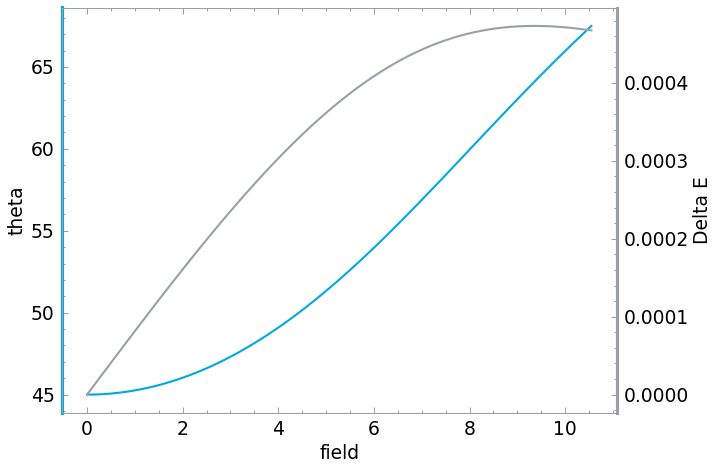

In [91]:
theta_0 = 45
plt.figure()
angel_change(np.linspace(0, B_sat, 100), theta_0).plot()
plt.ylabel("theta")
plt.gca().spines['left'].set_color('C0')
plt.gca().spines['left'].set_linewidth(1.5)
plt.twinx()
center_offset(np.linspace(0, B_sat, 100), theta_0).plot(color="C1")
plt.gca().spines['right'].set_color('C1')
plt.gca().spines['right'].set_linewidth(1.5)
plt.ylabel("Delta E")
plt.show()

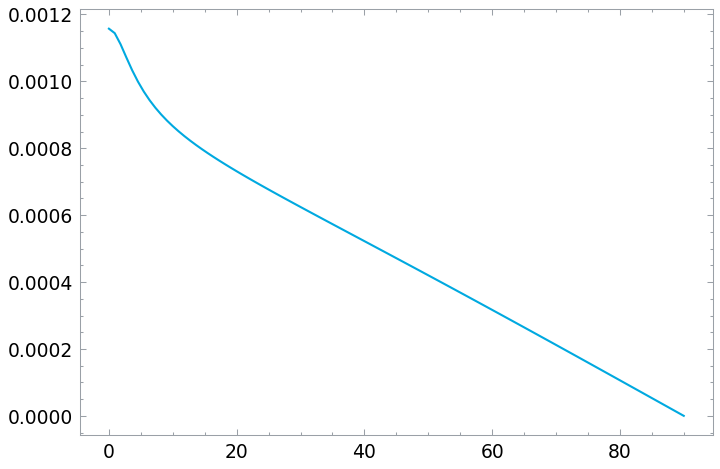

In [92]:
plt.figure()
plt.plot(
    *np.array([(a, calculate_center_offset(np.array([0, 10]), a)[1]) for a in np.linspace(0, 90, 100)]).T
)

In [5]:
# recreate using numba
import numba
import numpy as np

@numba.jit()
def numba_peak(wavelengths:np.array, center:np.array, width:float, height=1.):
    # energy = 1239.84193/wavelengths
    # counts = np.exp(-((energy - center) / width) ** 2)
    counts = np.exp(-1/2 * ((wavelengths - 1239.84193/center) / width) ** 2)
    return counts*height

numba_peak(np.linspace(839, 841, 100), ev_to_nm(840), .0001)

@numba.jit()
def numba_polarized_peak(
        wavelengths:np.array, angles:np.array, 
        angle:float, degree:float, center:float, width:float, height=1
    ):
    angle_factors = degree * np.cos(np.deg2rad(angles - angle)) ** 2 + 1.0-degree
    counts = numba_peak(wavelengths, center, width, height)[:, np.newaxis] * angle_factors

    return counts

numba_polarized_peak(
    np.linspace(839, 841, 100), np.linspace(0, 180, 3), 
    angle=45, degree=.5, center=ev_to_nm(840), width=.0001, height=1
)

B_sat = 10.55
g=2
mu_bohr = 5.788e-5

@numba.jit()
def numba_angel_change(B:np.array, theta_0:float, B_sat=B_sat):
    return np.arctan2(
        np.sin(2*theta_0*np.pi/180), 
        np.cos(2*theta_0*np.pi/180)-(B/B_sat)**2
    )/2 * 180/np.pi

numba_angel_change(np.linspace(0, B_sat, 100), theta_0=45.0)

@numba.jit()
def numba_calculate_center_offset(B:np.array, theta_0=0.0, g=g, B_sat=B_sat): 
    return g*mu_bohr*np.cos(numba_angel_change(B, theta_0=theta_0, B_sat=B_sat)*np.pi/180)*B

numba_calculate_center_offset(np.linspace(0, B_sat, 100), theta_0=45)

@numba.jit()
def numba_center_offset(B:np.array, theta_0=45.0, g=g, B_sat=B_sat):
    ar = numba_calculate_center_offset(B, theta_0=theta_0, g=g, B_sat=B_sat)
    ar = ar + numba_calculate_center_offset(np.array([0]), theta_0=theta_0, g=g, B_sat=B_sat)[0]
    return ar

numba_center_offset(np.linspace(0, B_sat, 100), theta_0=45)

@numba.jit()
def numba_peak_over_field_pair(
        wavelengths:np.array, angles:np.array, fields:np.array,
        theta_0:float, degree:float, center:float, width:float, height=1,
        g=g, B_sat=B_sat  
    ):
    pol_angles = numba_angel_change(fields, theta_0, B_sat)
    center_offsets = numba_center_offset(fields, theta_0, g, B_sat)

    ar = np.zeros((len(wavelengths), len(angles), len(fields)))
    for i in range(len(fields)):
        ar[:, :, i] = numba_polarized_peak(
            wavelengths, angles,
            angle=pol_angles[i], degree=degree, center=center+center_offsets[i], width=width, height=height
        ) + numba_polarized_peak(
            wavelengths, angles,
            angle=pol_angles[i], degree=degree, center=center-center_offsets[i], width=width, height=height
        )


    return ar

numba_peak_over_field_pair(
    np.linspace(839, 841, 100), np.arange(0, 180, 1), np.linspace(0, 10, 10),
    theta_0=42.0, degree=.5, center=ev_to_nm(840), width=.5e-3, height=1
)


def peak_over_field_pair(
        wavelengths:np.array, angles:np.array, fields:np.array,
        theta_0:float, degree:float, center:float, width:float, height=1,
        g=g, B_sat=B_sat  
    ):
    ar = xr.DataArray(
        numba_peak_over_field_pair(
            wavelengths, angles, fields, theta_0, degree, center, width, height, g, B_sat
        ),
        coords={"wavelength": wavelengths, "angle": angles, "field": fields}
    )
    ar = ar.assign_coords({"energy": ev_to_nm(ar.wavelength)})
    return ar

def polarized_peak(
        wavelengths:np.array, angles:np.array, 
        angle:float, degree:float, center:float, width:float, height=1
    ):
    ar = xr.DataArray(
        numba_polarized_peak(
            wavelengths, angles, angle, degree, center, width, height
        ),
        coords={"wavelength": wavelengths, "angle": angles}
    )
    ar = ar.assign_coords({"energy": ev_to_nm(ar.wavelength)})
    return ar


In [94]:
%%timeit
_ = peak_over_field_pair(
    np.linspace(839, 841, 50), np.array([0, 90]), np.linspace(0, 10, 10),
    theta_0=42, degree=.5, center=ev_to_nm(840), width=.5e-3, height=1
)

971 µs ± 134 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84193/ev


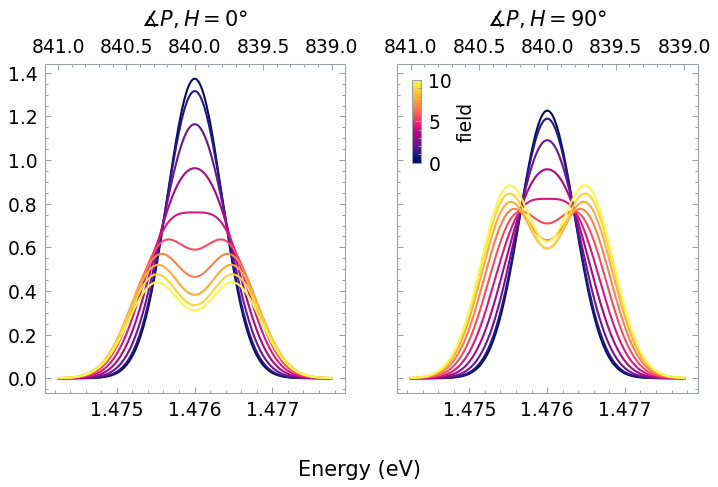

In [95]:
sel = peak_over_field_pair(
    np.linspace(839, 841, 200), np.array([0, 90]), np.linspace(0, 10, 10),
    theta_0=42, degree=.7, center=ev_to_nm(840), width=.2, height=1
)

angles = [0, 90]
fig, axs = plt.subplots(1, len(angles), sharex=True, sharey=True)
field = np.linspace(0, sel.field.max(), 10)
color = cm["CET_L8"](field / field.max())

def pre(d):
    return d

for ang, ax in zip(angles, axs):
    for f, c in zip(field, color):
        pre(sel).sel(angle=ang).interp(field=f).plot(
            ax=ax, 
            color=c,
            x="energy",
        )
    ax.set_title(fr"$\measuredangle P,H = {float(ang):.0f}°$")
    ax.set_xlabel("")
    ax.set_ylabel("")
    plot.energy_ticks(ax)


fig.supxlabel("Energy (eV)", fontsize=FONTSIZE)


# add colorbar with field
sm = plt.cm.ScalarMappable(cmap=cm["CET_L8"], norm=plt.Normalize(vmin=0, vmax=10))
sm.set_array([])
# insert axs for colorbar into axs[-1]
cax = axs[-1].inset_axes([0.05, 0.7, 0.03, 0.25])
fig.colorbar(sm, cax=cax, label=r"field")
plt.tight_layout()

plt.show()

# Import Data

In [6]:
# import backgrounds
paths = glob("../data/2023-12-05*/d*.asc")
paths += glob("../data/2023-12-06*/d*.asc")
paths += glob("../data/2023-12-07*/d*.asc")
paths += glob("../data/2023-12-12*/d*.asc")
paths += glob("../data/2023-12-13*/d*.asc")
paths += glob("../data/2023-12-14*/d*.asc")
paths += glob("../data/2023-12-19*/d*.asc")
paths += glob("../data/2023-12-20*/d*.asc")
paths += glob("../data/2023-12-21*/d*.asc")
paths += glob("../data/2023-12-22*/d*.asc")
paths += glob("../data/2024-01-09*/d*.asc")
paths = [p for p in paths if "bkg" in p]
paths.sort()

import csv

def _read_csv(path):
	rows = []
	with open(path) as f:
		r = csv.reader(f, delimiter="\t")
		for row in r:
			if len(row) == 0:
				return rows
			rows.append(row)
	return rows

def custom_import_spectra(p):
	d = np.array(_read_csv(p))[:, :-1]
	# convert strings to floats
	d = d.astype(float)

	ar = xr.DataArray(
		d[:, 1],
		coords={
			'wavelength': d[:, 0]
		}
	)

	# get the metadata
	number, exposure = p.replace(".", "_").split("s")[0].split("_")[-1].split("x")

	ar.attrs = {
		**ar.attrs,
		"path": p.split("data/")[-1],
		"name": p.split("data/")[-1].split(".")[0],
		"number": int(number),
		"exposure": float(exposure),
	}
	ar.name = ar.attrs["name"]
	
	return ar

bkg = [custom_import_spectra(p) for p in paths]
bkg_new = bkg.copy()

bkg[0] = bkg[0] / 3
bkg[1] = bkg[1] / 3
bkg[2] = bkg[2] / 5

import difflib

def background_substract_old(sel, b=None):
	if b is np.nan:
		return None
	if b is None:		
		same_folder = [b for b in bkg if sel.name.split("/")[0] in b.name]
		if len(same_folder) == 1: b=same_folder[0]
		elif len(same_folder) > 1:
			b_name = difflib.get_close_matches(sel, [b.name for b in same_folder], n=1, cutoff=0)[0]
			b = [b for b in same_folder if b.name == b_name][0]
		else:
			before = [b for b in bkg if b.name < sel.name]
			if before:
				b = sorted(before, key=lambda x: x.name)[-1]
			else:
				b = sorted(bkg, key=lambda x: x.name)[0]
	
	d =  sel - b.interp(wavelength=sel.wavelength, kwargs={"fill_value": np.nan})
	d.attrs = sel.attrs
	d.name = sel.name
	d.attrs["background"] = b

	d = d.dropna("wavelength")

	d /= d.attrs["number"]
	d /= d.attrs["exposure"]

	return d


bkg = bkg_new

# create a script that
def background_substract(sel, b=None):
	if b is not None:
		return background_substract_old(sel, b)
	
	exposure = sel.attrs["exposure"]
	wavelength = (sel.wavelength.min(), sel.wavelength.max())

	# get all backgrounds with the same exposure
	same_exposure = [b for b in bkg if b.attrs["exposure"] == exposure]

	# find the same wavelength
	same_wavelength = [b for b in same_exposure if b.wavelength.min() <= wavelength[0] and b.wavelength.max() >= wavelength[1]]

	# if there is only one, use it
	if len(same_wavelength) == 1: b=same_wavelength[0]

	# if there are more, use the one with the closest wavelength
	elif len(same_wavelength) > 1:
		b_name = difflib.get_close_matches(sel, [b.name for b in same_wavelength], n=1, cutoff=0)[0]
		b = [b for b in same_wavelength if b.name == b_name][0]
	
	else:
		# check if there is a partial match of the wavelength
		partial_match = [b for b in same_exposure if b.wavelength.min() <= wavelength[0] or b.wavelength.max() >= wavelength[1]]
		if len(partial_match) == 1: b=partial_match[0]
		
		# take the closest one
		elif len(partial_match) > 1:
			# b_name = difflib.get_close_matches(sel, [b.name for b in partial_match], n=1, cutoff=0)[0]
			# b = [b for b in partial_match if b.name == b_name][0]
			b = sorted(partial_match, key=lambda x: np.abs(x.wavelength.mean() - sel.wavelength.mean()))[0]
		
		else:
			warnings.warn(f"no background found for {sel.name}")
			return sel
	
	return background_substract_old(sel, 
		b * sel.attrs["number"] / b.attrs["number"]
	)


pprint([b.name for b in bkg])



['2023-12-05_LO_MG_NiPS3/d001_bkg_15x5s',
 '2023-12-07_LO_MG_NiPS3/d003_bkg_15x5s',
 '2023-12-13_CrPS4_outPlane/d001_bkg_25x5s_horPol',
 '2023-12-14_CrPS4_outPlane/d002_bkg_25x3s',
 '2023-12-14_CrPS4_outPlane/d008_bkg_25x10s',
 '2023-12-20_NiPS3_inPlane/d002_bkg_10x10s',
 '2023-12-20_NiPS3_inPlane/d005_bkg_25x5s_smaller_slit',
 '2023-12-21_NiPS3_inPlane/d001_bkg_10x10s',
 '2023-12-22_NiPS3_inPlane/d001_bkg_5x5s',
 '2024-01-09_NiPS3_inPlane/d002_bkg_5x10s']


In [7]:
# import all from 2023-12-06 and 07 done with custom script
import h5py

paths = glob("../data/2023-12-05*/*hd5.h5")
paths += glob("../data/2023-12-06*/*.h5")
paths += glob("../data/2023-12-07*/*.h5")
paths += glob("../data/2023-12-08*/*.h5")
paths += glob("../data/2023-12-11*/*.h5")
paths += glob("../data/2023-12-12*/*.h5")
paths += glob("../data/2023-12-13*/*.h5")
paths += glob("../data/2023-12-14*/*.h5")
paths += glob("../data/2023-12-15*/*.h5")
paths += glob("../data/2023-12-18*/*.h5")
paths += glob("../data/2023-12-19*/*.h5")
paths += glob("../data/2023-12-20*/*.h5")
paths += glob("../data/2023-12-21*/*.h5")
paths += glob("../data/2023-12-22*/*.h5")
paths += glob("../data/2024-01-09*/*.h5")
paths += glob("../data/2024-02-14*/*.h5")
paths += glob("../data/2024-02-15*/*.h5")
paths += glob("../data/2024-02-16*/*.h5")
paths.sort()

# paths = list(filter(lambda p: "hd5" not in p, paths))

def import_custom_script(p):
	with h5py.File(p, "r") as f:
		angle_count = len(np.unique(f['apt_angle']))

		if "magnet_field" in f:
			field = f["magnet_field"][::angle_count]
		else:
			field = np.array([np.nan])

		angle = f["apt_angle"][:angle_count]
		wavelength = f["wavelength"][0]
		counts = f["counts"][:].reshape(field.shape[0], angle.shape[0], wavelength.shape[0])

		time = f["time"][:].reshape(field.shape[0], angle.shape[0])

		if "temperature" in f:
			temperature = f["temperature"][:].reshape(field.shape[0], angle.shape[0])
		else:
			temperature = np.full_like(time, np.nan)

		if "position" in f:
			position = f["position"][:].reshape(field.shape[0], angle.shape[0], 3)
		else:
			position = np.full_like(counts, np.nan)

		exposure = f["data_full"]["spectrometer"]["exposure"][0]
		number = f["data_full"]["spectrometer"]["number"][0]

	ar = xr.DataArray(
		counts,
		dims=["field", "angle", "wavelength"],
		coords={
			"field": field,
			"angle": angle,
			"wavelength": wavelength,
		},
		attrs={
			"exposure": exposure,
			"number": number,
		}
	)

	# add coord time
	ar.coords["time"] = (
		["field", "angle"],
		time
	)

	# add coord temperature
	ar.coords["temperature"] = (
		["field", "angle"],
		temperature
	)

	return ar

def import_files(p):

	try:
		ar = import_custom_script(p)
	except:
		print(f"Error importing:\t{p}")
		return None

	# if ar is None:
		# return None
	
	ar.attrs = {
		**ar.attrs,
		"path": p.split("data/")[-1],
		"name": ".".join(p.split("data/")[-1].split(".")[:-1]),
	}
	ar.name = ar.attrs["name"]


	diff_field = np.diff(ar.field)
	if np.all(diff_field > 0):
		ar.attrs["field_direction"] = 1.
	elif np.all(diff_field < 0):
		ar.attrs["field_direction"] = -1.
	else:
		ar.attrs["field_direction"] = np.nan

	return ar

data_import = [import_files(p) for p in paths]
data_import = [d for d in data_import if d is not None]
data_import = [background_substract(d) for d in data_import]
data = [d for d in data if d.name not in [d.name for d in data_import]]
data += data_import

Error importing:	../data/2023-12-05_LO_MG_NiPS3/d004_10K_647nm_rotPolDet_26degPolExc_flake04.hd5.h5
Error importing:	../data/2023-12-06_LO_MG_NiPS3/d001_50K_647nm_rotPolDet_flake04_sweepUp_inPlane.hd5.h5
Error importing:	../data/2023-12-06_LO_MG_NiPS3/d002_10K_647nm_rotPolDet_flake04_sweepDown_inPlane.hd5.h5
Error importing:	../data/2023-12-06_LO_MG_NiPS3/d003_pol_10K_flake05.hd5.h5
Error importing:	../data/2023-12-06_LO_MG_NiPS3/d004_10K_647nm_rotPolDet_flake05_sweepDown_inPlane.hd5.h5
Error importing:	../data/2024-02-15 CrPS4 outPlane linPolExc linPolDet/d002_45K.hd5.h5
Error importing:	../data/2024-02-15 CrPS4 outPlane linPolExc linPolDet/d003_5K.hd5.h5


/tmp/ipykernel_190874/3642480946.py:128: UserWarning: no background found for 2024-02-14 CrPS4 outPlane linPolExc linPolDet/d001_280K.hd5_6
  warnings.warn(f"no background found for {sel.name}")
/tmp/ipykernel_190874/3642480946.py:128: UserWarning: no background found for 2024-02-14 CrPS4 outPlane linPolExc linPolDet/d002_100K.hd5_4
  warnings.warn(f"no background found for {sel.name}")
/tmp/ipykernel_190874/3642480946.py:128: UserWarning: no background found for 2024-02-15 CrPS4 outPlane linPolExc linPolDet/d001_70K.hd5_5
  warnings.warn(f"no background found for {sel.name}")
/tmp/ipykernel_190874/3642480946.py:128: UserWarning: no background found for 2024-02-15 CrPS4 outPlane linPolExc linPolDet/d002_45K.hd5_1
  warnings.warn(f"no background found for {sel.name}")
/tmp/ipykernel_190874/3642480946.py:128: UserWarning: no background found for 2024-02-15 CrPS4 outPlane linPolExc linPolDet/d003_5K.hd5_1
  warnings.warn(f"no background found for {sel.name}")
/tmp/ipykernel_190874/3642480

In [8]:
# add energy coordinates
data = [d.assign_coords(energy=1239.84193/d.wavelength) for d in data]
data = [d.assign_coords(angle=2*d.angle) for d in data]

# Evaluate Data with Model

In [9]:
sel_all =  [d for d in data if "Ni" in d.name and "inPlane" in d.name and ("linPol" in d.name or "linDet" in d.name and "field" in d.coords and 10. in d.field)]
pprint({i:d.name for i,d in enumerate(sel_all)})

sel = sel_all[13]
pprint(sel.name)

# def pre(d):
# 	d = d.\
# 	rolling(wavelength=3, center=True).mean().\
# 	sortby("field")
# 	d = d.sel(wavelength=slice(836, 842))
# 	d = d - estimate_bkg(d)
# 	# d = d.sel(wavelength=slice(839.2, 841.2))
# 	d = d.where(~np.isnan(d), drop=True)
# 	d = d.assign_coords({"energy": ev_to_nm(d.wavelength)})
# 	d = d / d.mean("wavelength") * d.mean()
# 	return d

{0: '2023-12-06_LO_MG_NiPS3/d006_flake01_10K_inPlane_linPol',
 1: '2023-12-07_LO_MG_NiPS3/d001_flake06_50K_inPlane_linPol',
 2: '2023-12-07_LO_MG_NiPS3/d002_flake04_50K_inPlane_linPol_sweepDown',
 3: '2023-12-07_LO_MG_NiPS3/d005_flake04_50K_inPlane_linPol_sweepUp',
 4: '2023-12-07_LO_MG_NiPS3/d006_flake04_50K_inPlane_linPol_sweepDown',
 5: '2023-12-08_LO_MG_NiPS3/d001_flake04_50K_inPlane_linPol_sweepUp',
 6: '2023-12-08_LO_MG_NiPS3/d002_flake04_50K_inPlane_linPol_hysteresis',
 7: '2023-12-11_NiPS3/d003_flake04_50K_linPol_inPlane',
 8: '2023-12-20_NiPS3_inPlane/d001_circPolExc_linDetPol_10K_flake02_2mW',
 9: '2023-12-20_NiPS3_inPlane/d003_circPolExc_linDetPol_10K_flake02_2mW_smallerSlit',
 10: '2023-12-20_NiPS3_inPlane/d005_circPolExc_linDetPol_10K_flake08_2mW_smallerSlit_filmBeamsplitter',
 11: '2023-12-20_NiPS3_inPlane/d006_circPolExc_linDetPol_10K_flake08_2mW_smallerSlit',
 12: '2023-12-21_NiPS3_inPlane/d002_circPolExc_linDetPol_50K_flake01_1mW',
 13: '2023-12-22_NiPS3_inPlane/d002_c

## Remove Background

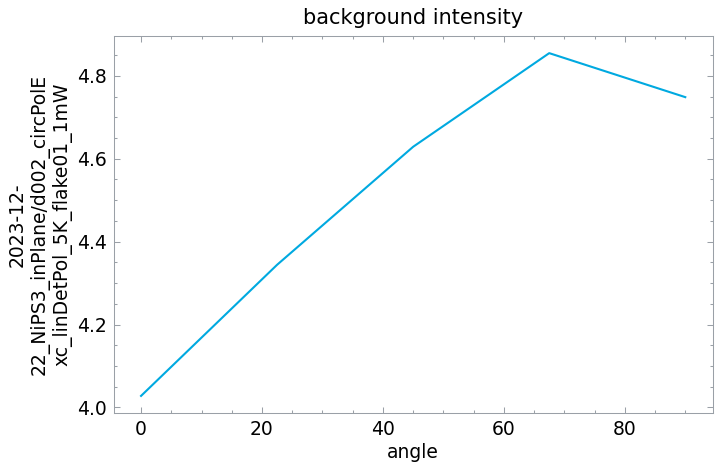

In [107]:
plt.figure()
sel.sel(wavelength=slice(845, 860)).mean("wavelength").plot()
plt.title("background intensity")
plt.show()

# sel.sel(angle=0).plot.imshow()

/home/leon/.local/lib/python3.11/site-packages/xarray/plot/dataarray_plot.py:2316: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(y[0], y[-1])


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

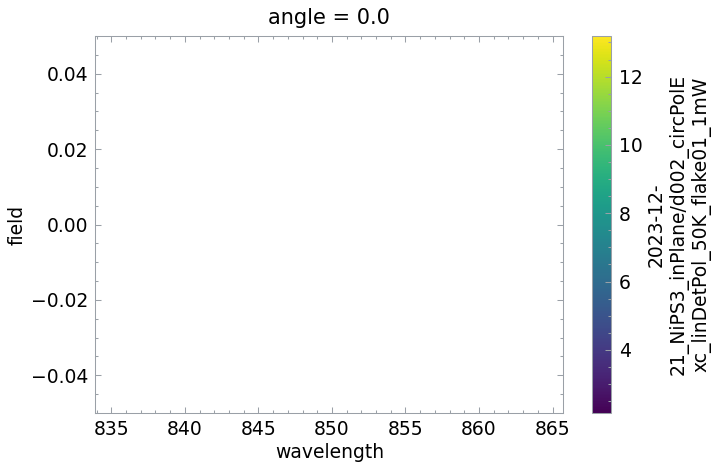

In [128]:
plt.figure()
wl_slice_bkg = slice(845, 860)

bkg = sel.sel(wavelength=wl_slice_bkg).mean("wavelength")


(sel).sel(angle=0, field=0).plot()
plt.axhline(
    bkg.sel(angle=0, field=0).values
)
plt.axvspan(
    wl_slice_bkg.start, wl_slice_bkg.stop,
    color="C1", alpha=.3
)

In [10]:
def background_substract(d):
    bkg = d.sel(wavelength=slice(845, 860)).mean("wavelength")
    d= d - bkg
    return d


def pre(d):
    d = background_substract(d)
    d = d.sel(wavelength=slice(838, 842))
    d = d.assign_coords({"energy": ev_to_nm(d.wavelength)})
    return d

## Look at data

/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84193/ev
/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84193/ev


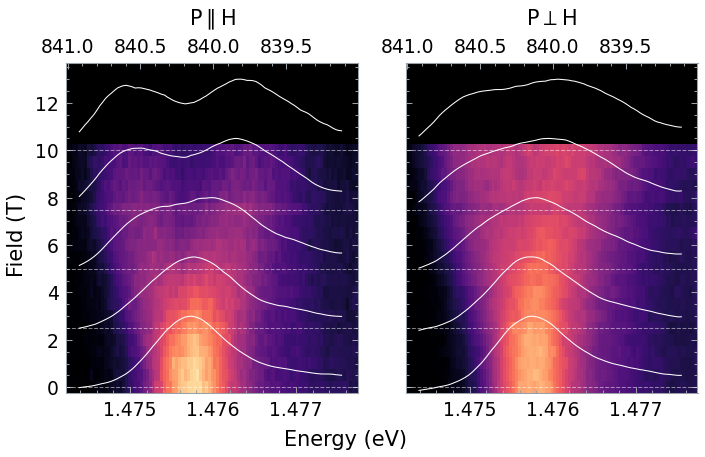

In [16]:
def plot_splitting(s, figsize=FIGSIZE_LARGE, energy_axis=True):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=figsize)

    vmax = s.max()

    for ax, angle in zip(axs, [0, 90]):
        s = s.sel(wavelength=slice(839, 841))
        s = s.rolling_exp(wavelength=2, center=True).mean()
        s.sel(angle=angle).plot.imshow(
            ax=ax, cmap=CMAP, x="energy", y="field",
            add_labels=False,
            add_colorbar=False,
            vmax=vmax,
            vmin=0,
            rasterized=True
        )
        if angle == 0:
            ax.set_title("P$\parallel$H")
        elif angle == 90:
            ax.set_title("P$\perp$H")
        else:
            ax.set_title(fr"$\measuredangle P,H = {angle}°$")
        if energy_axis: plot.energy_ticks(ax, locator=False)

    # plot in white for some field
    for (ang, ax) in zip([0., 90.], axs):
        for f in np.linspace(0, 10., 5):
            d = s.sel(angle=ang)
            d = d.interp(field=f)
            d = d.rolling(wavelength=10, center=True).mean()
            d = d/vmax
            d = d/d.max()
            d = d*3
            pos = f
            ax.axhline(pos, color="white", lw=.5, linestyle="dashed", alpha=.5)
            ax.plot(
                d.energy, d+pos,
                color="white",
                lw=.5
            )
        # ax.set_ylim(None, 12)
        ax.set_facecolor("black")


    fig.supxlabel("Energy (eV)", fontsize=FONTSIZE, y=0.07)
    fig.supylabel("Field (T)", fontsize=FONTSIZE, x=0.05)

    plt.tight_layout()

    return fig
fig = plot_splitting(normalize(pre(sel)))
fig.savefig("../report/figures/2024-04-10 NiPS4 splitting.pdf")


{0: '2023-12-06_LO_MG_NiPS3/d006_flake01_10K_inPlane_linPol',
 1: '2023-12-07_LO_MG_NiPS3/d001_flake06_50K_inPlane_linPol',
 2: '2023-12-07_LO_MG_NiPS3/d002_flake04_50K_inPlane_linPol_sweepDown',
 3: '2023-12-07_LO_MG_NiPS3/d005_flake04_50K_inPlane_linPol_sweepUp',
 4: '2023-12-07_LO_MG_NiPS3/d006_flake04_50K_inPlane_linPol_sweepDown',
 5: '2023-12-08_LO_MG_NiPS3/d001_flake04_50K_inPlane_linPol_sweepUp',
 6: '2023-12-08_LO_MG_NiPS3/d002_flake04_50K_inPlane_linPol_hysteresis',
 7: '2023-12-11_NiPS3/d003_flake04_50K_linPol_inPlane',
 8: '2023-12-20_NiPS3_inPlane/d001_circPolExc_linDetPol_10K_flake02_2mW',
 9: '2023-12-20_NiPS3_inPlane/d003_circPolExc_linDetPol_10K_flake02_2mW_smallerSlit',
 10: '2023-12-20_NiPS3_inPlane/d005_circPolExc_linDetPol_10K_flake08_2mW_smallerSlit_filmBeamsplitter',
 11: '2023-12-20_NiPS3_inPlane/d006_circPolExc_linDetPol_10K_flake08_2mW_smallerSlit',
 12: '2023-12-21_NiPS3_inPlane/d002_circPolExc_linDetPol_50K_flake01_1mW',
 13: '2023-12-22_NiPS3_inPlane/d002_c

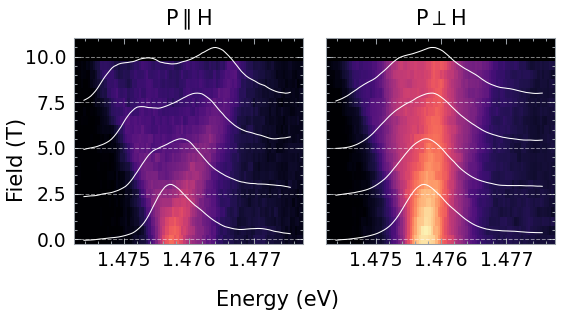

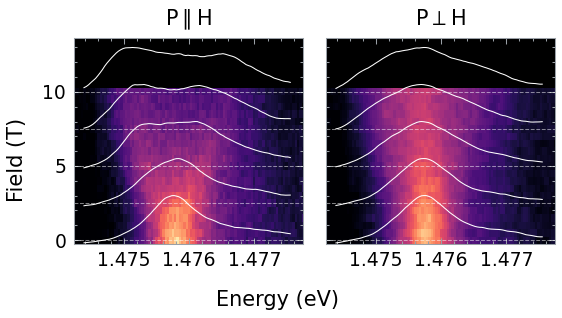

In [52]:
pprint({i:d.name for i,d in enumerate(sel_all)})

# fig = plot_splitting(normalize(pre(sel_all[13])), figsize=(4, FIGSIZE_MEDIUM[1]), energy_axis=False)
# fig.savefig("../report/figures/2024-04-18 NiPS4 splitting 5K.pdf");

fig = plot_splitting(normalize*pre(sel_all[9]), figsize=(4, FIGSIZE_MEDIUM[1]), energy_axis=False)
fig.savefig("../report/figures/2024-04-18 NiPS4 splitting 10K.pdf");

fig = plot_splitting(normalize*pre(sel_all[11]).isel(field=slice(0,20)), figsize=(4, FIGSIZE_MEDIUM[1]), energy_axis=False)
fig.savefig("../report/figures/2024-04-18 NiPS4 splitting 10K multiple flakes.pdf");

# fig = plot_splitting(normalize*pre(sel_all[12]).isel(field=slice(0,20)), figsize=(4, FIGSIZE_MEDIUM[1]), energy_axis=False)
# # fig = plot_splitting(pre(sel_all[7]).isel(field=slice(0,20)), figsize=(4, FIGSIZE_MEDIUM[1]), energy_axis=False)
# fig.axes[0].set_ylim(0, None)
# fig.savefig("../report/figures/2024-04-18 NiPS4 splitting 50K.pdf");

/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84193/ev
/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84193/ev


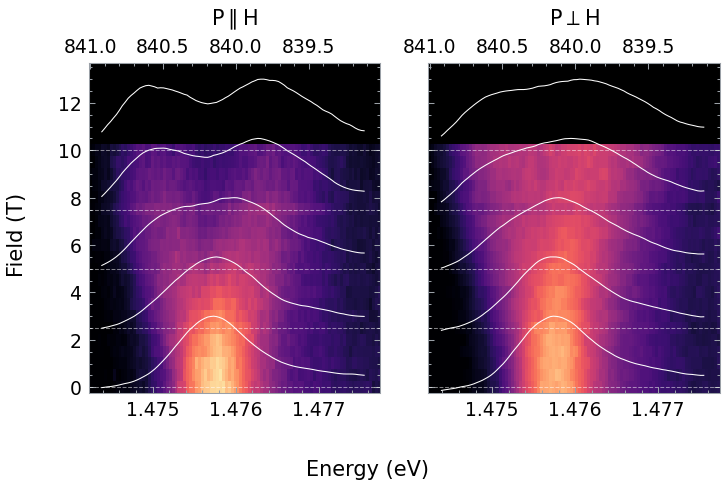

In [46]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

s = pre(sel)
s = s/s.mean(["wavelength", "angle"])

vmax = s.max()

for ax, angle in zip(axs, [0, 90]):
    s = s.sel(wavelength=slice(839, 841))
    s = s.rolling_exp(wavelength=2, center=True).mean()
    s.sel(angle=angle).plot.imshow(
        ax=ax, cmap=CMAP, vmin=0, x="energy", y="field",
        add_labels=False,
        add_colorbar=False,
        vmax=vmax,
        rasterized=True
    )
    if angle == 0:
        ax.set_title("P$\parallel$H")
    elif angle == 90:
        ax.set_title("P$\perp$H")
    else:
        ax.set_title(fr"$\measuredangle P,H = {angle}°$")

    plot.energy_ticks(ax, locator=False)

# plot in white for some field
for (ang, ax) in zip([0., 90.], axs):
    for f in np.linspace(0, 10., 5):
        d = s.sel(angle=ang)
        d = d.interp(field=f)
        d = d.rolling(wavelength=10, center=True).mean()
        d = d/vmax
        d = d/d.max()
        d = d*3
        pos = f
        ax.axhline(pos, color="white", lw=.5, linestyle="dashed", alpha=.5)
        ax.plot(
            d.energy, d+pos,
            color="white",
            lw=.5
        )
    # ax.set_ylim(None, 12)
    ax.set_facecolor("black")


fig.supxlabel("Energy (eV)", fontsize=FONTSIZE)
fig.supylabel("Field (T)", fontsize=FONTSIZE)

plt.savefig("../report/figures/2024-04-10 NiPS4 splitting.pdf")
plt.show()


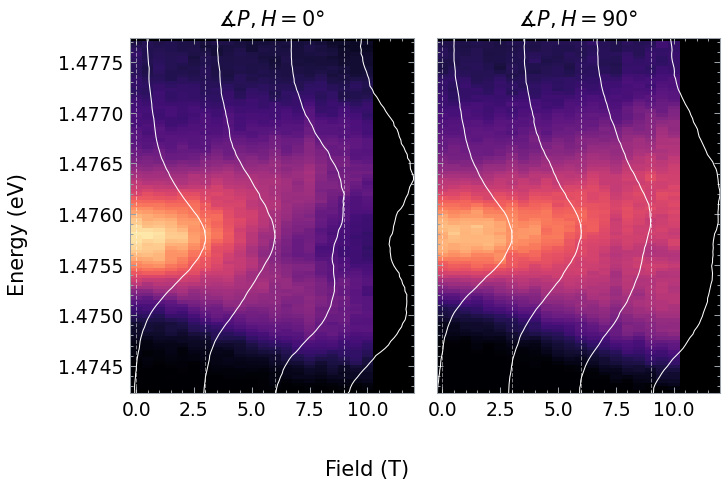

In [53]:
# plot the result
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

s = pre(sel)
s = normalize(s)
vmax = s.sel(angle=[0,90]).max()

wavelength_slice = slice(839, 841)

fields = np.linspace(0, sel.field.max(), 11)
colors = cm["CET_L8"](fields / fields.max())

for i, (ang, ax) in enumerate(zip([0., 90.], axs)):
    d = s.sel(angle=ang)
    d = d.sel(wavelength=wavelength_slice)
    d = d.rolling(wavelength=3, center=True).mean()
    d.plot(
        ax=ax, cmap=CMAP, vmin=0, add_colorbar=False, 
        vmax=vmax, 
        x="field", y="energy", 
        add_labels=False, rasterized=True,
    )
    
    # plt.colorbar(ax.collections[0], ax=ax)

    ax.set_title(fr"$\measuredangle P,H = {ang:.0f}°$")
    # ax.yaxis.set_ticks_position('left')

# plot in white for some field
for (ang, ax) in zip([0., 90.], axs):
    for f in np.arange(0, 10.1, 3):
        d = s.sel(angle=ang)
        d = d.interp(field=f)
        d = d.rolling(wavelength=10, center=True).mean()
        d = d/vmax
        d = d/d.max()
        d = d*3
        pos = f
        ax.axvline(pos, color="white", lw=.5, linestyle="dashed", alpha=.5)
        ax.plot(
            d+pos, d.energy,
            color="white",
            lw=.5
        )
    ax.set_xlim(None, 12)
    # set facecolor to black
    ax.set_facecolor("black")



plot.hide_inner_label()
# axs[-1].yaxis.set_ticks_position('left')
# secax = axs[-1].secondary_yaxis("right", functions=(nm_to_ev, ev_to_nm))


fig.supxlabel("Field (T)", fontsize=FONTSIZE)
fig.supylabel("Energy (eV)", fontsize=FONTSIZE)
plt.tight_layout()
# plt.savefig("../report/figures/2024-04-07 NiPS3 Splitting.pdf")
plt.show()

/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84193/ev


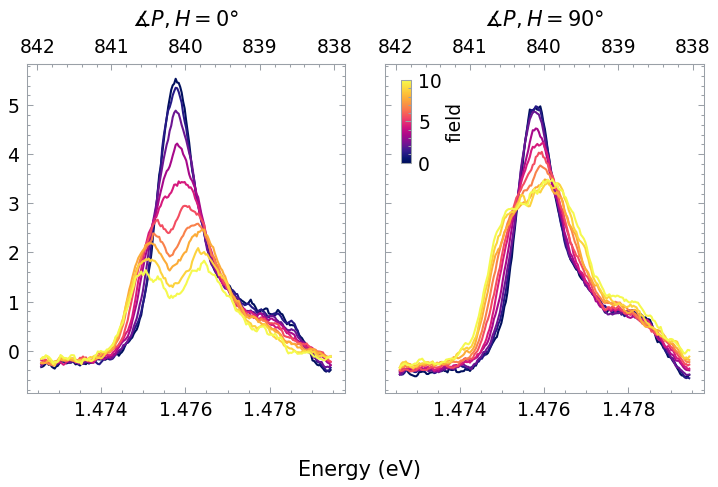

In [54]:
angles = [0, 90]
fig, axs = plt.subplots(1, len(angles), sharex=True, sharey=True)

field = np.linspace(0, sel.field.max(), 10)
color = cm["CET_L8"](field / field.max())

for ang, ax in zip(angles, axs):
	for f, c in zip(field, color):
		s=pre(sel)
		s = s/s.mean(["wavelength", "angle"])
		s = s.rolling(wavelength=5, center=True).mean()
		s.sel(angle=ang).interp(field=f).plot(
			ax=ax, 
			color=c,
			x="energy",
		)
	ax.set_title(fr"$\measuredangle P,H = {float(ang):.0f}°$")
	ax.set_xlabel("")
	ax.set_ylabel("")
	plot.energy_ticks(ax)


fig.supxlabel("Energy (eV)", fontsize=FONTSIZE)

# add colorbar with field
sm = plt.cm.ScalarMappable(cmap=cm["CET_L8"], norm=plt.Normalize(vmin=0, vmax=10))
sm.set_array([])
# insert axs for colorbar into axs[-1]
cax = axs[-1].inset_axes([0.05, 0.7, 0.03, 0.25])
fig.colorbar(sm, cax=cax, label=r"field")
plt.tight_layout()

plt.show()

## Fit Model

[25, 0.9, 3, 0.23, 840.12]


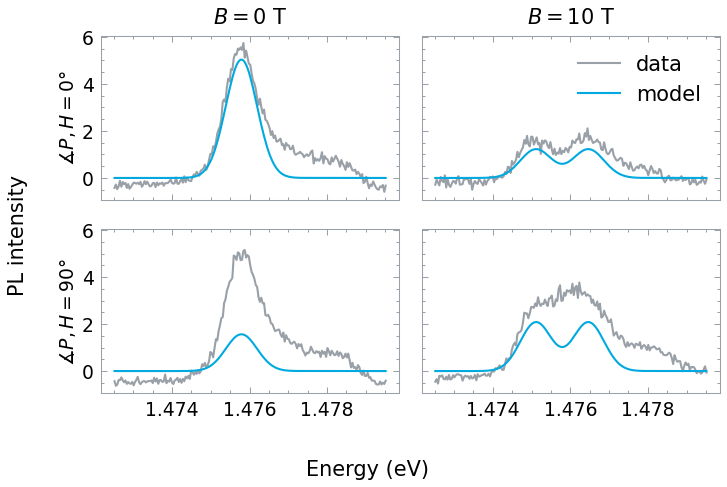

In [11]:
# optiomize using scipy
from scipy.optimize import minimize, basinhopping
wavelength_slice = slice(839.7, 841.5)

sel_0field_mean = sel.sel(wavelength=wavelength_slice, field=0).mean("angle")
center_wl =  np.average(sel_0field_mean.wavelength.values, weights=sel_0field_mean.values)
width =  np.average((center_wl - sel_0field_mean.wavelength.values)**2, weights=sel_0field_mean.values)*2


def model(param, sel):
    return peak_over_field_pair(
        sel.wavelength.values, sel.angle.values, sel.field.values,
        theta_0=param[0], degree=param[1], center=ev_to_nm(param[4]), width=param[3], height=param[2]
    ) \
    # + polarized_peak(
    #     sel.wavelength.values, sel.angle.values, 
    #     angle=param[5], degree=param[6], center=ev_to_nm(param[7]), width=param[8], height=param[9] 
    # )


def error(param, sel):
    # sel = sel.sel(angle=[0., 90.])
    # sel = sel.sel(field=[0., 10.])
    # sel = sel.sel(wavelength=wavelength_slice)
    
    error = (sel - model(param, sel))
    error = np.abs(error)
    # error = error**2

    # error = error * sel**2
    error = error.sum()

    return error

# param = [44, 1, 17, width*1.5, center_wl]
param = [
    # 44, .9, 5, .23, 840.12,
    25, .9, 3, .23, 840.12,
    #  45, .1, 839.5, .5, 3
]

print(param)

# param = [3.76984812e+01, 8.79006845e-02, 6.02891613e-04, 7.14610822e+00, 4.03628349e+00]

if False:
    res = minimize(error, param, args=(normalize(sel)), 
        method="Nelder-Mead",
        # method="Powell",
        # method="BFGS",
        # options={"disp": True},
        # tol=1e-10,
        # bounds=[
        #     (0, 180),
        #     (.7, 1),
        #     (5, 20),
        #     (.1*width, 10*width),
        #     (center_wl-1, center_wl+1)
        # ]
    )

    # res = basinhopping(error, param, minimizer_kwargs={"args": (sel)}, disp=True, 
    #     method="Powell",
    # )

    assert res.success
    pprint(res.x)
    param = res.x

# plot the result
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

vmax = sel.max()

fields = np.linspace(0, sel.field.max(), 11)
colors = cm["CET_L8"](fields / fields.max())

for field, ax_i in zip([0., 10.], axs.T):

    for i, (ang, ax) in enumerate(zip([0., 90.], ax_i)):
        normalize(pre(sel)).sel(angle=ang, field=field).plot(ax=ax, x="energy", _labels={}, color="C1")
        model(param, pre(sel)).sel(angle=ang, field=field).plot(ax=ax, x="energy", _labels={}, color="C0")
        # ax.set_title(fr"$\measuredangle P,H = {ang:.0f}°$" + "\t" + fr"$B = {field}$ T")
        # ax.axvspan(ev_to_nm(wavelength_slice.start), ev_to_nm(wavelength_slice.stop), color="C1", alpha=.2, lw=0)

# for a in axs[0]: plot.energy_ticks(a)
plot.hide_inner_label()

axs[0, 1].legend(["data", "model"])

for a, l in zip(axs[0,:], [0, 10]): a.set_title(f"$B = {l}$ T")
for a, l in zip(axs[:,0], [0, 90]): a.set_ylabel(fr"$\measuredangle P,H = {l:.0f}°$")

fig.supxlabel("Energy (eV)", fontsize=FONTSIZE)
fig.supylabel("PL intensity", fontsize=FONTSIZE)

# plt.savefig("../report/figures/2024-04-07 NiPS3 Model Fit Problem.pdf")

plt.show()

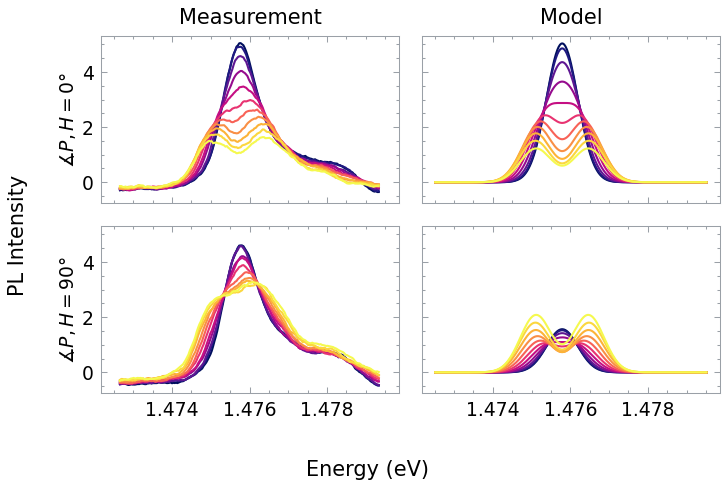

In [12]:
# plot the result
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

vmax = sel.max()


fields = np.linspace(0, sel.field.max(), 11)
colors = cm["CET_L8"](fields / fields.max())

for i, (ang, ax) in enumerate(zip([0., 90.], axs.T[0])):
    # sel.sel(angle=ang).plot(ax=ax, y="wavelength", cmap=CMAP, vmin=0, add_colorbar=False, vmax=vmax)
    # plt.colorbar(ax.collections[0], ax=ax)

    for i, f in enumerate(fields):
        (normalize(smooth*pre(sel))).sel(angle=ang).interp(field=f).plot.line(ax=ax, x="energy", color=colors[i], _labels=False)
    # ax.set_ylabel("Data")
    # ax.set_title(fr"Measurement, $\measuredangle P,H = {ang:.0f}°$")
    
    # insert thext in plot
    # ax.text(.05, .9, "Measurement", transform=ax.transAxes, fontsize=FONTSIZE)

for i, (ang, ax) in enumerate(zip([0, 90], axs.T[1])):
    # model(param, sel).sel(angle=ang).plot(ax=ax, cmap=CMAP, vmin=0, vmax=vmax, add_colorbar=False)
    for i, f in enumerate(fields):
        model(param, pre(sel)).sel(angle=ang).interp(field=f).plot.line(ax=ax, x="energy", color=colors[i], _labels=False)
    # ax.set_ylabel("Model")
    # ax.set_title(fr"Model, $\measuredangle P,H = {ang:.0f}°$")

# for ax in axs[0,:]: plot.energy_ticks(ax)
for ax, t in zip(axs[0,:], ["Measurement", "Model"]): ax.set_title(t)
for ax, t in zip(axs[:,0], [0, 90]): ax.set_ylabel(fr"$\measuredangle P,H = {t}°$")
plot.hide_inner_label()

fig.supxlabel("Energy (eV)", fontsize=FONTSIZE)
fig.supylabel("PL Intensity", fontsize=FONTSIZE)

plt.tight_layout()
# plt.savefig("../report/figures/2024-04-07 NiPS3 Model.pdf")
plt.show()

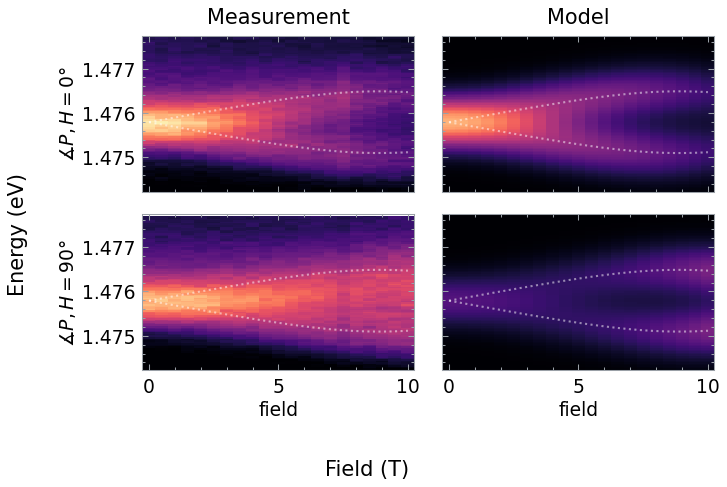

In [13]:
# plot the result
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

s = normalize(pre(sel))
vmax = s.sel(angle=[0, 90]).max()

wavelength_slice = slice(839, 841)

fields = np.linspace(0, sel.field.max(), 11)
colors = cm["CET_L8"](fields / fields.max())

for i, (ang, ax) in enumerate(zip([0., 90.], axs.T[0])):
    d = s
    d = d.sel(angle=ang)
    d = d.sel(wavelength=wavelength_slice)
    d = d.rolling(wavelength=2, center=True).mean()
    d.plot(ax=ax, cmap=CMAP, vmin=0, add_colorbar=False, vmax=vmax, x="field", y="energy", rasterized=True)
    ax.set_title(fr"")
    # plt.colorbar(ax.collections[0], ax=ax)

    # add wavelength ticks as y axis
    # ax.secondary_yaxis("right", functions=(nm_to_ev, ev_to_nm))

    # ax.set_ylabel("Data")
    # ax.set_title(fr"$\measuredangle P,H = {ang:.0f}°$")


for i, (ang, ax) in enumerate(zip([0, 90], axs.T[1])):
    model_run = model(param, pre(sel))
    model_run = model_run.sel(wavelength=wavelength_slice)
    vmax = model_run.max()
    # model_run = normalize(model_run)
    model_run.assign_coords({"energy": ev_to_nm(model_run.wavelength)})
    model_run.sel(angle=ang).plot(ax=ax, cmap=CMAP, vmin=0, vmax=vmax, add_colorbar=False, y="energy", x="field", rasterized=True)
    ax.set_title("")
    # ax.set_ylabel("Model")
    # ax.set_title(fr"$\measuredangle P,H = {ang:.0f}°$")
    # ax.secondary_yaxis("right", functions=(nm_to_ev, ev_to_nm))

# add model as line
field = np.linspace(0, 10, 100)
offset = numba_center_offset(field, param[0], g, B_sat)
# offset = numba_center_offset(field, 25, g, B_sat)
for ax in axs.flatten():
    ax.plot(field, ev_to_nm(param[4])+offset, "w:", alpha=.5)
    ax.plot(field, ev_to_nm(param[4])-offset, "w:", alpha=.5)


for ax, t in zip(axs[0,:], ["Measurement", "Model"]): ax.set_title(t)
for ax, t in zip(axs[:,0], [0, 90]): ax.set_ylabel(fr"$\measuredangle P,H = {t}°$")
plot.hide_inner_label()

fig.supylabel("Energy (eV)", fontsize=FONTSIZE)
fig.supxlabel("Field (T)", fontsize=FONTSIZE)

# plt.savefig("../report/figures/2024-04-09 NiPS3 model comparison.pdf")
plt.show()

# Polarisation

CPU times: user 1.57 s, sys: 1.8 s, total: 3.36 s
Wall time: 2.2 s


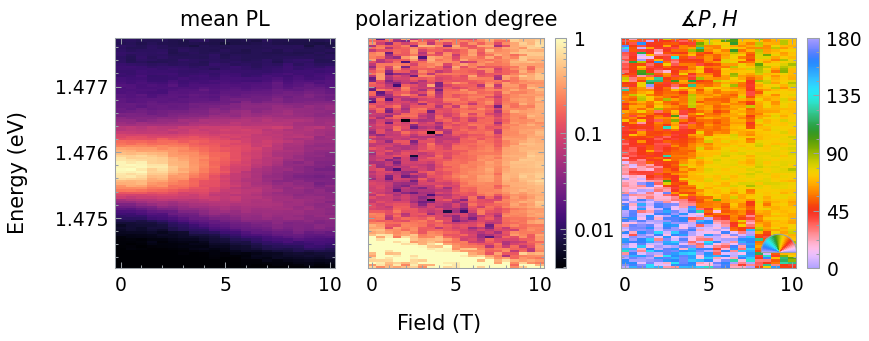

In [55]:
%%time

from matplotlib.ticker import LogFormatter, ScalarFormatter, FormatStrFormatter

def custom_polarisation(sel):
	# sel = sel.coarsen(wavelength=sel.wavelength.shape[0]//50, boundary="trim").mean()
	sel = sel.where(~np.isnan(sel), drop=True)
	pol = polarisation_xarray(sel.assign_coords(angle=sel.angle))
	pol = pol.sortby("field")
	return pol


def plot_fig(sel, save=False, log=True):
	pol = custom_polarisation(sel)
	# fig = plt.figure(figsize=FIGSIZE_WIDE)
	fig, axs = plt.subplots(1, 3, figsize=(6, 2.5), sharex=True, sharey=True)
	# plt.suptitle(sel.name)
	# plot.energy_ticks()
	(
		unploarized(normalize*sel.sortby("field"))
	).plot(
		add_labels=False, 
		add_colorbar=False,
		cmap=CMAP,
	 	rasterized=True,
		vmin=0,
		x="field", y="energy",
		ax=axs[0]
	)
	axs[0].set_title(r"mean PL")

	# plot.energy_ticks()
	img = pol.polarisation\
	.plot(
		# vmin=0,
		# vmin=1e-2,
		vmax=1,
		add_labels=False,
		norm=mpl.colors.LogNorm() if log else None,
		cmap=CMAP,
		rasterized=True,
		x="field", y="energy",
		ax=axs[1],
		add_colorbar=False
	)
	plt.colorbar(img, ax=axs[1], format=FormatStrFormatter('%g'))
	axs[1].set_title("polarization degree")

	# ax.set_facecolor("black")
	# plot.energy_ticks()
	img = pol.angle\
	.plot(
		vmin=0, vmax=180,
		cmap=cm["CET_C6s"],
		add_labels=False,
		add_colorbar=False,
  		rasterized=True,
		x="field", y="energy",
		ax=axs[2]
	)
	plt.colorbar(img).ax.set_yticks(np.arange(0, 181, 45))
	plot.inset_cbar_polar(img.cmap)

	axs[2].set_title(r"$\measuredangle P,H$")

	plot.hide_inner_label()

	fig.supylabel("Energy (eV)", fontsize=FONTSIZE, x=0.02)
	fig.supxlabel("Field (T)", fontsize=FONTSIZE, y=0.07)

	plt.tight_layout()

	fig.subplots_adjust(wspace=0.15)
	
	return fig

plot_fig(
	normalize(pre(sel)).rolling_exp(wavelength=2, center=True).mean().sel(wavelength=slice(839, 841))
).savefig("../report/figures/2024-04-09 NiPS3 Polarisation Splitting.pdf")

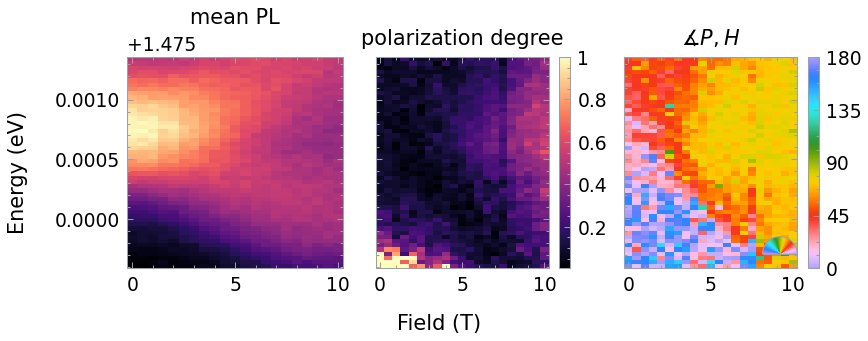

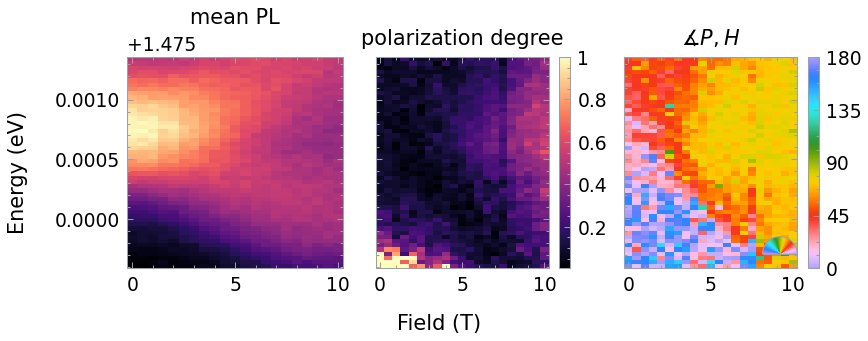

In [61]:
plot_fig(
	normalize(pre(sel)).rolling_exp(wavelength=2, center=True).mean().sel(wavelength=slice(839.8, 840.8)), log=False
)

In [41]:
def plot_fig_wo_degree(sel, save=False):
	pol = custom_polarisation(sel)
	# fig = plt.figure(figsize=FIGSIZE_WIDE)
	fig, axs = plt.subplots(1, 3, figsize=FIGSIZE_WIDE, sharex=True, sharey=True)
	# plt.suptitle(sel.name)
	# plot.energy_ticks()
	(
		unploarized(normalize*sel.sortby("field"))
	).plot(
		add_labels=False, 
		add_colorbar=False,
		cmap=CMAP,
	 	rasterized=True,
		vmin=0,
		x="field", y="energy",
		ax=axs[0]
	)
	axs[0].set_title(r"mean PL")

	# plot.energy_ticks()
	pol.polarisation\
	.plot(
		vmin=1e-2,
		# vmin=1e-3,
		vmax=1,
		add_labels=False,
		norm=mpl.colors.LogNorm(),
		cmap=CMAP,
		rasterized=True,
		x="field", y="energy",
		ax=axs[1]
	)
	axs[1].set_title("Polarisation degree")

	# ax.set_facecolor("black")
	# plot.energy_ticks()
	img = pol.angle\
	.plot(
		vmin=0, vmax=180,
		cmap=cm["CET_C6s"],
		add_labels=False,
		add_colorbar=False,
  		rasterized=True,
		x="field", y="energy",
		ax=axs[2]
	)
	plt.colorbar(img).ax.set_yticks(np.arange(0, 181, 45))
	plot.inset_cbar_polar(img.cmap)

	axs[2].set_title(r"$\measuredangle P,H$")

	fig.subplots_adjust(hspace=0, wspace=0)

	fig.supylabel("Energy (eV)", fontsize=FONTSIZE)
	fig.supxlabel("Field (T)", fontsize=FONTSIZE)
	plot.hide_inner_label()
	return fig

model_run = model(param, pre(sel))
model_run = model_run.sel(wavelength=slice(839, 841))
model_run.assign_coords({"energy": ev_to_nm(model_run.wavelength)})
plot_fig_wo_degree(model_run).savefig("../report/figures/2024-04-09 NiPS3 Model.pdf")

NameError: name 'model' is not defined

2023-12-15_CrPS4_inPlane/d001_linPolDet_circExcPol_10K_flake03_4mW


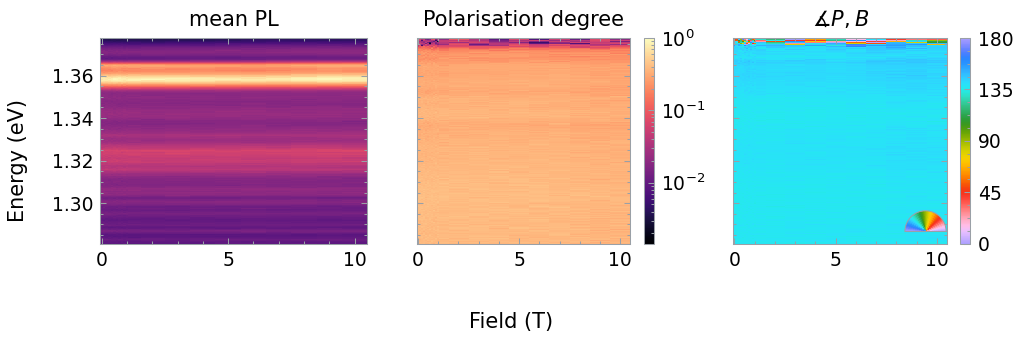

In [16]:
# plot the crPS4 data with the same art style
s = [d for d in data if "CrPS4" in d.name and "linPolDet" in d.name and "inPlane" in d.name and "10K" in d.name]
s = s[-1]

print(s.name)

plot_fig(
    s.sel(wavelength=slice(900, 1000))
).savefig("../report/figures/2024-04-09 CrPS4 linear Polarisation.pdf")

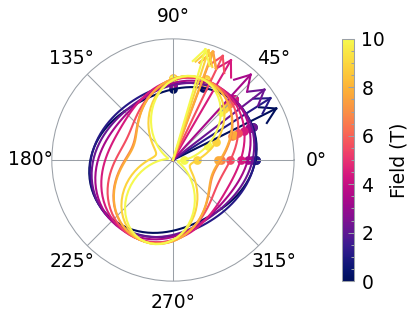

In [40]:
angle_offset = 0

def reduce_data(d):
	d = pre(d)
	d = d.sel(wavelength=slice(839, 841))
	d = normalize(d)
	# d = d.rolling(wavelength=3).mean()
	# d = d.sel(wavelength=840.25, method="nearest")
	d = d.mean("wavelength")
	return  d


def plot_fig(sel, save=False):
	field = np.linspace(sel.field.min(), sel.field.max(), 10)
	color = cm["CET_L8"](field / field.max())

	fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=FIGSIZE_MEDIUM)
	for f, c in zip(field, color):
		d = reduce_data(sel).interp(field=f)
		popt, pcov = sp.optimize.curve_fit(
			cos_sqr, sel.angle, d, p0=[1, 90, 0])

		s = np.abs(popt[0]) + popt[2]
		d = d/s

		d.assign_coords(angle=(sel.angle+angle_offset) * np.pi / 180)\
		.plot.scatter(
			ax=ax, 
			color=c,
			add_labels=False,
			s=10,
			x="angle",
		)

		# plot arrow
		# n = (popt[1]%90)+90+180
		n = (popt[1]%90)#+90+180

		# ax.plot(
		# 	[((popt[1]%90)+90+180)*np.pi/180], [1.2],
		# 	"x", color=c, markersize=5
		# )

		ax.plot(
			[n*np.pi/180, n*np.pi/180], [.4, 1.2],
			"-", color=c
		)

		# add arrow head
		ax.plot(
			[n*np.pi/180, (n+5)*np.pi/180], [1.2, 1.1],
			"-", color=c
		)
		ax.plot(
			[n*np.pi/180, (n-5)*np.pi/180], [1.2, 1.1],
			"-", color=c
		)

		angles = np.linspace(0, 360, 100)
		ax.plot((angles+angle_offset) * np.pi/180, cos_sqr(angles, *popt)/s, color=c)

	plt.yticks([])
	plt.ylim(.4, None)
	ax.set_rlabel_position(240)
	# plt.title("Polarisation of main PL line")
	# plt.suptitle(sel.name + "\n detected at 840.1 nm") 

	sm = plt.cm.ScalarMappable(cmap=cm["CET_L8"], norm=plt.Normalize(vmin=field.min(), vmax=field.max()))
	sm.set_array([])
	plt.colorbar(sm, ax=ax, label=r"Field (T)", pad=0.1)
	return fig


plot_fig(sel).savefig("../report/figures/2024-04-07 NiPS3 Polarisation.pdf")

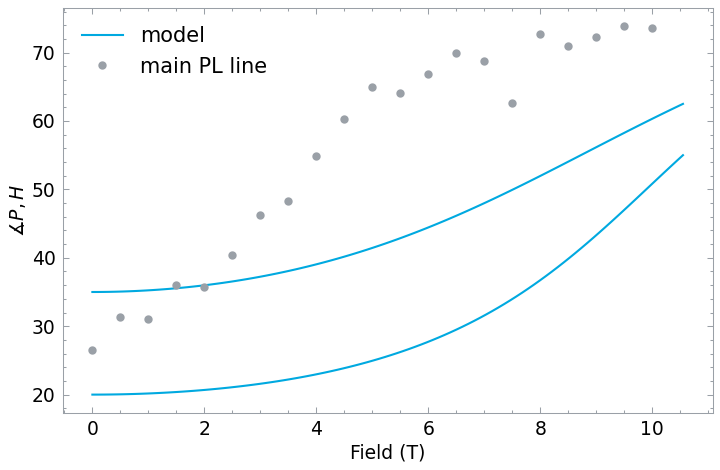

In [66]:
plt.figure()

# (polarisation_xarray(
# 	sel.rolling(wavelength=5).mean().sel(wavelength=840.25, method="nearest")
# )).angle.plot(label="840.1nm")

def angel_change(B:np.array, theta_0:float, B_sat=B_sat):
    ar = xr.DataArray(
        # theta_0 + B/B_sat * (90-theta_0),
        np.arctan2(
            np.sin(2*theta_0*np.pi/180), 
            np.cos(2*theta_0*np.pi/180)-(B/B_sat)**2
        )/2 * 180/np.pi,
        coords={"field": B}
    )
    return ar

line_model = (angel_change(np.linspace(0, B_sat, 100), theta_0=20)).plot(label="model")
(angel_change(np.linspace(0, B_sat, 100), theta_0=35)).plot(color=line_model[0].get_color())

(polarisation_xarray(
    reduce_data(normalize(sel))
).angle).plot(label="main PL line", linestyle="none", marker="o", markersize=3)

max_wl = sel.mean(["angle", "field"]).idxmax()

plt.xlabel("Field (T)")
plt.ylabel(r"$\measuredangle P,H$")

plt.title("")


plt.legend()
# plt.savefig("../report/figures/2024-04-07 NiPS3 Polarisation Problem.pdf")
plt.show()

# Mean Energy Shift

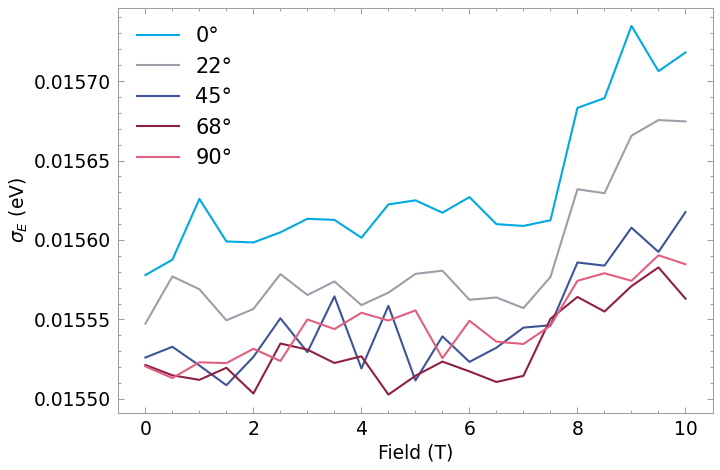

In [12]:
def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

mean = np.zeros((len(sel.angle), len(sel.field)))
std = np.zeros((len(sel.angle), len(sel.field)))

for i,a in enumerate(sel.angle):
    s = sel
    # s = s.rolling(wavelength=10, center=True).mean().dropna("wavelength")
    s = s.sel(angle=a)
    for j, f in enumerate(s.field):
        d = s.sel(field=f)
        mean[i, j] = weighted_avg_and_std(d.energy, d.values)[0]
        std[i, j] = weighted_avg_and_std(d.energy, d.values)[1]

plt.figure()
for i, a in enumerate(sel.angle):
    # plt.errorbar(sel.field, mean[i], yerr=std[i], label=f"{a:.0f}°")
    plt.plot(sel.field, std[i], label=f"{a:.0f}°")
    plt.legend()

plt.xlabel("Field (T)")
plt.ylabel("$\sigma_E$ (eV)")
plt.show()

{'A1': 16.294049753021838,
 'A2': -1.6150126712355604,
 'c': 0.017560074423675097,
 'mu1': 1.4758120837746098,
 'mu2': -1.0318169790079437,
 'sigma1': 0.00045648822789429687,
 'sigma2': -0.0008565286419380803}
delta E:	2507.63 meV


/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84193/ev


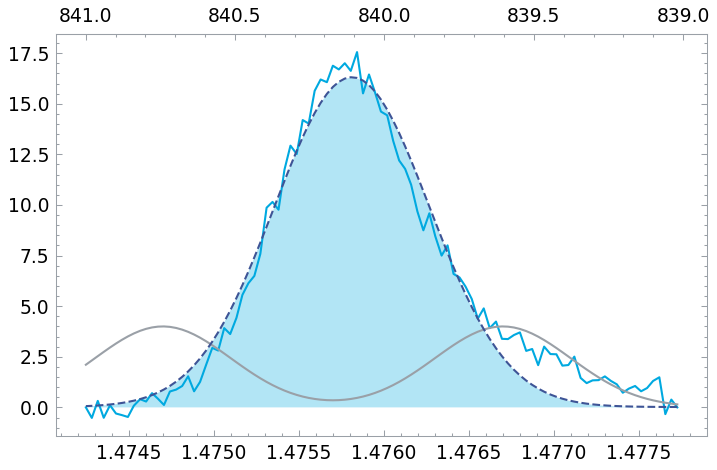

In [210]:
# find using peak fitting

s = sel.sel(field=0, angle=0, wavelength=slice(839, 841))
s = s - s.isel(wavelength=[0, -1]).interp(wavelength=s.wavelength)
s = s.assign_coords({"energy": ev_to_nm(s.wavelength)})
# s = s.sel(wavelength=slice(839.5,None))
# s = s.rolling(wavelength=3, center=True).mean()

def double_gauss(x, *p):
    x = ev_to_nm(x)
    A1, mu1, sigma1, A2, mu2, sigma2, c = p
    return A1*np.exp(-(x-mu1)**2/(2.*sigma1**2)) + A2*np.exp(-(x-mu2)**2/(2.*sigma2**2)) + c

def gauss(x, *p):
    x = ev_to_nm(x)
    A, mu, sigma = p[:3]
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# fit 
w = 0.0004
h = 4
c = 0
center = 1.4757
delta = 1e-3
p0 = [h-c, center-delta, w, h-c, center+delta, w, c]
# popt, pcov = sp.optimize.curve_fit(double_gauss, s.wavelength, s.values, p0=p0)

def error(p):
    error = np.power(s.values - double_gauss(s.wavelength, *p),2).sum()
    # error += 1e2 * error * (p[1]- p[4])**2 # mu
    # error += 1e3 * error * ((p[0]-p[3])/(p[0]+p[3]))**2 # A
    # error += 1e6 * error * ((p[2]-p[5])/(p[2]+p[5]))**2 # sigma
    return error

res = sp.optimize.minimize(error, p0, method="Nelder-Mead")

assert res.success
popt = res.x

pprint(
    dict(zip(["A1", "mu1", "sigma1", "A2", "mu2", "sigma2", "c"], popt))
)

print(f"delta E:\t{np.abs(popt[1]-popt[4])*1e3:.2f} meV")

plt.figure()
s.plot(x="energy", _labels=None)

e = s.energy
plt.plot(e, double_gauss(ev_to_nm(e), *p0))
plt.plot(e, double_gauss(ev_to_nm(e), *popt), "--")
plt.fill_between(e, gauss(ev_to_nm(e), *popt[:4]), alpha=.3)
plt.fill_between(e, gauss(ev_to_nm(e), *popt[3:]), alpha=.3)
plot.energy_ticks()
plt.show()

In [11]:
sigma = .4e-3

def double_gauss(x, *p):
    x = ev_to_nm(x)
    A1, mu1, sigma1, A2, mu2, sigma2, c = p
    return A1*np.exp(-(x-mu1)**2/(2.*sigma1**2)) + A2*np.exp(-(x-mu2)**2/(2.*sigma2**2)) + c

def constrained_double_gauss(x, *p):
    A, center, delta = p
    return double_gauss(x, A, center-delta, sigma, A, center+delta, sigma, 0)

def constrained_gauss(x, *p):
    x = ev_to_nm(x)
    A, mu = p[:2]
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

/tmp/ipykernel_139405/1326474916.py:22: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = sp.optimize.curve_fit(constrained_double_gauss, s.wavelength, s.values, p0=p0)


{'A': 4.045714010528453,
 'center': 1.475740536622925,
 'delta': 0.0006608124777768424}
delta E:	1.32 meV


/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84193/ev


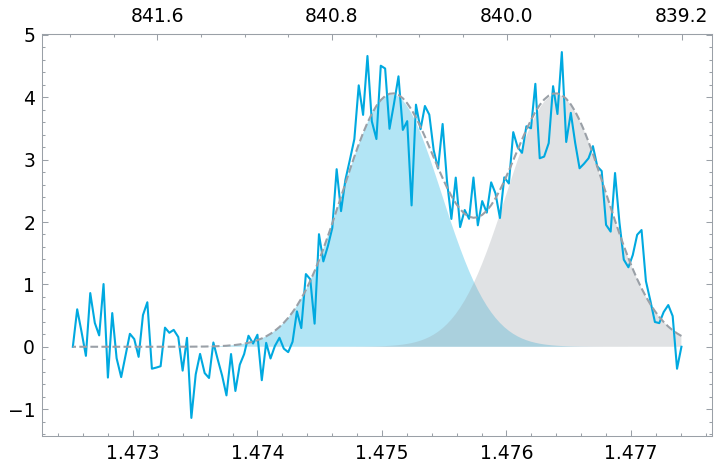

In [13]:
s = sel.sel(field=10, angle=0, wavelength=slice(839.2, 842))

# pad with zeros
# s = s.where(
#     s.wavelength > 839 and s.wavelength < 841,
#     0
# )
s = s - s.isel(wavelength=[0, -1]).interp(wavelength=s.wavelength)
s = s.assign_coords({"energy": ev_to_nm(s.wavelength)})
# s = s.sel(wavelength=slice(839.5,None))
# s = s.rolling(wavelength=3, center=True).mean()

# fit 
w = .4e-3
h = s.max()
c = 0
center = 1.4758
# center = np.average(s.energy, weights=s.values)
delta = .0e-3
# delta = np.average((s.energy-center)**2, weights=s.values) * 1e3
p0 = [h-c, center, delta]
popt, pcov = sp.optimize.curve_fit(constrained_double_gauss, s.wavelength, s.values, p0=p0)

def error(p):
    error = np.power(s.values - constrained_double_gauss(s.wavelength, *p),2).sum()
    # error = (np.power(s.values - constrained_double_gauss(s.wavelength, *p),2) * s.values**2).sum()
    # error = (np.power(s.values - constrained_double_gauss(s.wavelength, *p),2)*np.abs(s.values)).sum()
    # error += 1e-1 * error * p[2]**2
    return error
res = sp.optimize.minimize(error, p0, method="Nelder-Mead")
assert res.success
popt = res.x

pprint(
    dict(zip(["A", "center", "delta"], popt))
)

print(f"delta E:\t{np.abs(2*popt[2])*1e3:.2f} meV")

plt.figure()
s.plot(x="energy", _labels=None)

e = s.energy
# plt.plot(e, constrained_double_gauss(ev_to_nm(e), *p0))
plt.plot(e, constrained_double_gauss(ev_to_nm(e), *popt), "--")
plt.fill_between(e, constrained_gauss(ev_to_nm(e), popt[0], popt[1]-popt[2]), alpha=.3)
plt.fill_between(e, constrained_gauss(ev_to_nm(e), popt[0], popt[1]+popt[2]), alpha=.3)
plot.energy_ticks()
plt.show()

In [15]:
%%time
# fit all the data
def fit(s):
    # fit 
    h = s.max()
    center = 1.4758
    delta = .0
    p0 = [h, center, delta]
    popt, pcov = sp.optimize.curve_fit(constrained_double_gauss, s.wavelength, s.values, p0=p0)

    def error(p):
        error = np.power(s.values - constrained_double_gauss(s.wavelength, *p),2).sum()
        return error
    res = sp.optimize.minimize(error, p0, method="Nelder-Mead")
    assert res.success
    popt = res.x
    return popt

from concurrent.futures import ProcessPoolExecutor
def fit_all_parallel():
    d = sel.sel(wavelength=slice(839.2, 842))

    with ProcessPoolExecutor() as executor:
        fit_data = np.array(list(executor.map(fit, [d.sel(angle=a, field=f) for a in d.angle for f in d.field])))
    return fit_data.reshape(d.angle.size, d.field.size, 3)

fit_data = fit_all_parallel()

delta_E = np.abs(4*fit_data[:,:,2])*1e3
delta_E = delta_E - delta_E[:,0].min()
delta_E = xr.DataArray(
    delta_E,
    coords={"angle": sel.angle, "field": sel.field}
)

center = xr.DataArray(
    fit_data[:,:,1],
    coords={"angle": sel.angle, "field": sel.field}
)

<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters cou

<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters could not be estimated
<timed exec>:8: OptimizeWarning: Covariance of the parameters cou

CPU times: user 193 ms, sys: 264 ms, total: 458 ms
Wall time: 7.99 s


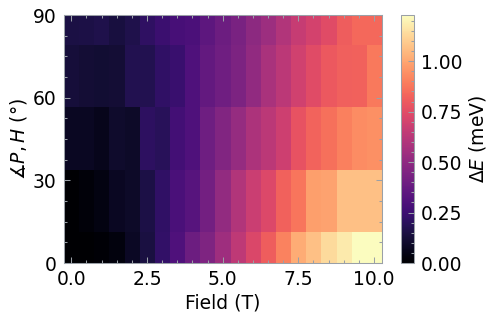

In [100]:
plt.figure(figsize=FIGSIZE_MEDIUM)
img = delta_E.plot.imshow(
    # interpolation="bicubic",
    cmap=CMAP,
    vmin=0,
    add_colorbar=False
)
plt.colorbar(img, label="$\Delta E$ (meV)")
plt.xlabel("Field (T)")
plt.ylabel(r"$\measuredangle P,H$ (°)")
plt.yticks(np.arange(0, 91, 30))
plt.ylim(0,90)

plt.savefig("../report/figures/2024-04-21 NiPS3 DeltaE.pdf")
plt.show()

/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84193/ev


/home/leon/Projekte/batchelorarbeit/src/lib/utils.py:7: RuntimeWarning: divide by zero encountered in divide
  return 1239.84193/ev


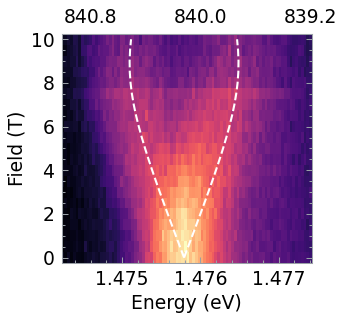

In [99]:
angle = 0 
s = sel
s = normalize(s)
s = s.sel(angle=angle, wavelength=slice(839.2, 841))


def model(sel, param):
    return peak_over_field_pair(
        sel.wavelength.values, np.array([angle]), sel.field.values,
        theta_0=param[0], degree=param[1], center=ev_to_nm(param[4]), width=param[3], height=param[2]
    )

def error(param):
    error = np.abs(s - model(s, param)).sum()
    return error

p0 = [
    25, .9, 3, .23, 840.12,
]

# res = sp.optimize.minimize(error, p0, 
#         method="Nelder-Mead"
# )

# assert res.success

# popt = res.x

popt = p0

plt.figure(figsize=(FIGSIZE_SMALL[0], FIGSIZE_MEDIUM[1]))

s.plot(
    x="energy", y="field", 
    cmap=CMAP,
    add_labels=False,
    add_colorbar=False,
    rasterized=True
)

# # plot double gauss fit
# offset = -.1e-3
# (center+delta_E/2e3 + offset).sel(angle=angle).plot(
#     y="field",
#     color="w",
#     linestyle="dotted"
# )
# (center-delta_E/2e3 + offset).sel(angle=angle).plot(
#     y="field",
#     color="w",
#     linestyle="dotted"
# )



offset = numba_center_offset(s.field.values, popt[0], g, B_sat)

center = ev_to_nm(popt[4])

for i in [1,-1]:
    plt.plot(
        i*offset+center,
        s.field,
        color="white",
        linestyle="--"
    )

plot.energy_ticks(locator=True, n_ticks=3)

plt.xlabel("Energy (eV)")
plt.ylabel("Field (T)")

plt.savefig("../report/figures/2024-04-21 NiPS3 single polarisation.pdf")
plt.show()


In [52]:

float(ev_to_nm(s.sel(field=0).idxmax()))

1.4758424086862219